# Database Analysis Code

Contains code to analyse the training set dataset used for the MPScore. This includes: identifying the functional groups present in the training database; an analysis of the consistency between chemists and the correlation between the SAScore, SCScore and chemist data.

In [ ]:
from sqlalchemy import create_engine
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
import json
from collections import defaultdict
from rdkit.Chem import AllChem as rdkit
import csv
from rdkit.Chem.MolStandardize import standardize_smiles
import seaborn as sns
from rdkit import Chem
from matplotlib import pyplot as plt
import itertools as it
from pymongo import MongoClient
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, pairwise_distances_argmin_min
from functools import cache
import stk
import py3Dmol
from scipy.stats import spearmanr

In [ ]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [ ]:
# Define synthetic accessibility scorers
from rdkit.Chem import RDConfig
import os
import sys
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
main_dir = Path("..").resolve()
sys.path.append(str(main_dir))

import sascorer as sascore
sascorer = lambda x: sascore.calculateScore(cached_smiles_converter(x))
from utilities.scscore.standalone_model_numpy import SCScorer
scscore = SCScorer()
scscore.restore()
scscorer = cache(scscore.get_score_from_smi)


# Load MPScore
from scripts.mpscore import MPScore
mpscore_path = Path("../models/mpscore_calibrated.joblib").resolve()
# Apply global cache to some functions to speed up restarts
model = MPScore(param_path=str(Path("../scripts/hyperparameters/optimal_params.json").resolve()))
model.restore(str(mpscore_path))
model.predict_proba = cache(model.predict_proba)

sascore_scaler = lambda x: (x-1)/(10-1)
scscore_scaler = lambda x: (x-1)/(5-1)
# Create some cached function to speed up repeat computation
cached_smiles_converter = lambda x: rdkit.AddHs(rdkit.MolFromSmiles(x))
cached_smiles_converter = cache(cached_smiles_converter)
cached_standardize_smiles = cache(standardize_smiles)

In [ ]:
# Analysing the functional groups in the training dataset
def find_functional_groups():
    training_db = "../data/training_mols.json"
    with open(training_db, "r") as f:
        training_db = json.load(f)
    fg_smarts = {
        'amine': ('[N]([H])[H]'),
        'aldehyde': ('[C](=[O])[H]'),
        'carboxylic_acid': ('[C](=[O])-[O][H]'),
        'fluorine': ('[F]'),
        'chlorine': ('[Cl]'),
        'bromine': ('[Br]'),
        'iodine': ('[I]'),
        'astatine': ('[As]'),
        'alcohol': ('[C]([H])([H])-[O][H]'),
        'alcohol2': ('[O][H]'),
        'alkene': ('[C]=[C]([H])[H]'),
        'alkyne': ('[C]#[C][H]'),
        'thiol': ('[S][H]'),
        'amide': ('[C](=[O])[N]([H])[H]'),
        'boronic_acid': ('[B]([O][H])[O][H]'),
        'xenon': ('[Xe]'),
        'methyl': ('[C]([H])([H])[H]'),
        'ethyl': ('[C]([H])([H])[C]([H])([H])[H]'),
        'propyl': ('[C]([H])([H])[C]([H])([H])[C]([H])([H])[H]'),
    }
    fg_counter = defaultdict(int)
    removed = []
    for inchi in tqdm(training_db):
        mol = Chem.AddHs(Chem.MolFromInchi(inchi))
        for fg in fg_smarts:
            fg_smart = fg_smarts[fg]
            counter = 0
            substruct = Chem.MolFromSmarts(fg_smart)
            matches = mol.GetSubstructMatches(substruct)
            counter += len(matches)
            # Ignore molecules if functional groups are less than two.
            if counter >= 2:
                fg_counter[f'{fg}_{counter}'] += 1
                removed.append(inchi)
                break
    sorted_db_funcs = sorted(fg_counter.items(), key=lambda x: x[0])
    db_funcs = pd.DataFrame(sorted_db_funcs)
    return db_funcs
db_fgs = find_functional_groups()

In [ ]:
# Analysing chemist scores
def load_chemist_data():
    main_dir = Path('..').resolve()
    p1 = main_dir.joinpath("data/chemist_data/opinions_becky.json")
    p2 = main_dir.joinpath("data/chemist_data/opinions_mebriggs.json")
    p3 = main_dir.joinpath("data/chemist_data/filip.csv")
    # Finding disagreements in training data
    with open(str(p1)) as f:
        rg = json.load(f)
    with open(str(p2)) as f:
        mb = json.load(f)
    with open(str(p3)) as f:
        reader = csv.reader(f, delimiter='\t')
        fs = {rdkit.MolToInchi(rdkit.MolFromSmiles(smi)): sco for sco, smi in reader}
    def parse_training(training_dict):
        d = defaultdict(list)
        for inchi in training_dict:
            # Convert and standardise SMILES string.
            d['smiles'].append(standardize_smiles(rdkit.MolToSmiles(rdkit.MolFromInchi(inchi))))
            d['chemist_score'].append(int(training_dict[inchi]))
        return pd.DataFrame(d)
    fs = parse_training(fs)
    rg = parse_training(rg)
    mb = parse_training(mb)
    # Molecules scored by all three chemists
    all_three = rg.rename(columns={'chemist_score': 'RLG'}).merge(fs.rename(columns={'chemist_score': 'FS'}), on='smiles').merge(mb.rename(columns={'chemist_score': 'MB'}), on='smiles')
    # Molecules scored by two chemists
    two = pd.concat([rg.merge(fs, on='smiles'), fs.merge(mb, on='smiles'), rg.merge(mb, on='smiles')])
    mols = [] 
    rows = []
    count = 0
    for i, r in all_three.iterrows():
        if (int(r.RLG) != int(r.FS)) or (int(r.FS) != int(r.MB)):
            count+=1
            rows.append(r)
            mols.append(r.smiles)
    print(f"There were {len(all_three)} molecules labelled by all three chemists")
    print(f"{count} molecules were labelled the same by all three chemists and {len(all_three)-count} were labelled differently.")
    count = 0
    column_names = ['RLG', 'FS', 'MB']
    df1 = rg.merge(fs, on='smiles')
    df1[~df1['smiles'].isin(all_three['smiles'])]
    df2 = rg.merge(mb, on='smiles')
    df2[~df2['smiles'].isin(all_three['smiles'])]
    df3 = fs.merge(mb, on='smiles')
    df3[~df3['smiles'].isin(all_three['smiles'])]
    for r in pd.concat([df1, df2, df3]).itertuples():
        if (int(r.chemist_score_x) == int(r.chemist_score_y)):
            count+=1
    print(f'There were {count} molecules labelled the same out of those scored by two chemists.')
    print(f'There were {len(pd.concat([df1, df2, df3])) - count} molecules labelled differently out of those scored by two chemists.')
    print(f'RLG labelled {sum(rg.chemist_score)} easy-to-synthesise and {len(rg)-sum(rg.chemist_score)} difficult-to-synthesise')
    print(f'FS labelled {sum(fs.chemist_score)} easy-to-synthesise and {len(fs)-sum(fs.chemist_score)} difficult-to-synthesise')
    print(f'MB labelled {sum(mb.chemist_score)} easy-to-synthesise and {len(mb)-sum(mb.chemist_score)} difficult-to-synthesise')
    chemist_data = pd.concat([fs, mb, rg])
    return chemist_data
chemist_data = load_chemist_data()

In [441]:
# Correlation between the SAScore and SCScore
def plot_figure4(recalculate_scores=False):
    df_training = pd.read_csv(main_dir.joinpath('data/training_database.csv'))
    if recalculate_scores:
        df_training['sas'] = [sascorer(m) for m in tqdm(df_training['smiles'], desc="Calculating SAScores")]
        df_training['scs'] = [scscorer(m)[1] for m in tqdm(df_training['smiles'], desc="Calculating SCScores")]
    # Scaling scores between 0 and 1
    df_training['sas_norm'] = [(val-1)/(10-1) for val in df_training['sas'].to_list()]
    df_training['scs_norm'] = [(val-1)/(5-1) for val in df_training['scs'].to_list()]
    # Plotting SA-SCScore correlations.
    print(f"The correlation between the SAScore and SCScore is: {df_training['scs'].corr(df_training['sas'])}")
    sns.set_style('white')
    palette = sns.color_palette() 
    # Green = palette[2] = Easy-to-synthesise
    # Red = palette[3] = Difficult-to-synthesise 
    colors = [palette[3]] + [palette[2]]
    g = sns.jointplot(
        data=df_training,
        x='sas_norm',
        y='scs_norm',
        hue='chemist_score',
        palette=colors,
        space=0.3,
        xlim=[0,1.1],
        ylim=[0,1.1],
        s=2.7,
        linewidth=0.2,
        height=3.3
    )
    g.set_axis_labels(xlabel='SAScore', ylabel='SCScore', fontsize='medium')
    g.ax_joint.legend_.remove()
    g.ax_joint.tick_params('both', labelsize='medium')
    return g
fig4 = plot_figure4(recalculate_scores=False)

The correlation between the SAScore and SCScore is: 0.2732653645310837


In [467]:
plt.clf()
fig, ax = plt.subplots()
sns.histplot(df_training[df_training['chemist_score'] == 1]['scs_norm'], color='r', ax=ax)
sns.histplot(df_training[df_training['chemist_score'] == 0]['scs_norm'], color='b', ax=ax)

<AxesSubplot:xlabel='scs_norm', ylabel='Count'>

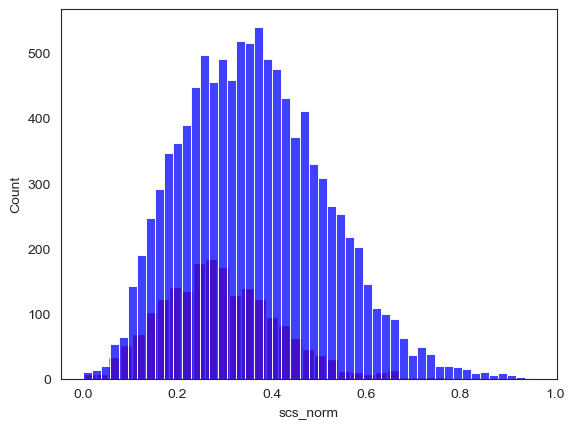

In [468]:
fig

In [438]:
sascorer('O=Cc1ccc(-c2nc(-c3ccc(C=O)cc3)nc(-c3ccc(C=O)cc3)n2)cc1')

6.518072712623623

In [ ]:
# Function for calculating SpearmanR on the training set of molecules
def calculate_spearman_r(recalculate_scores=False):
    df_training = pd.read_csv(main_dir.joinpath('data/training_database.csv'))
    if recalculate_scores:
        df_training['sas'] = [sascorer(m) for m in tqdm(df_training['smiles'], desc="Calculating SAScores")]
        df_training['scs'] = [scscorer(m)[1] for m in tqdm(df_training['smiles'], desc="Calculating SCScores")]
        df_training['mpscore'] = [model.predict_proba(cached_smiles_converter(m)) for m in tqdm(df_training['smiles'], desc="Calculating MPScores")]
    df_training['sas_norm'] = [(val-1)/(10-1) for val in df_training['sas'].to_list()]
    df_training['scs_norm'] = [(val-1)/(5-1) for val in df_training['scs'].to_list()]
    r_mp_sc = spearmanr(df_training['scs_norm'], df_training['mpscore'])
    r_mp_sa = spearmanr(df_training['sas_norm'], df_training['mpscore'])
    r_sa_sc = spearmanr(df_training['sas_norm'], df_training['scs_norm'])
    print(f'SpearmanR MP SC {r_mp_sc}')
    print(f'SpearmanR MP SA {r_mp_sa}')
    print(f'SpearmanR SA SC {r_sa_sc}')

In [ ]:
calculate_spearman_r(True)

In [ ]:
fig4.fig

## Identifying Most Similar/Different Molecules

The following functions contain code used to identify the most similar and different molecules from the SAScore, SCScore and MPScore. This finds the scores with the largest residual error from the line of best fit.

In [ ]:
def find_largest_residuals(x, y):
    eq = np.polyfit(x=x, y=y, deg=1)
    def calc_residual(eq, y_true, x):
        linear_func = lambda x: eq[0]*x+eq[1]
        y_pred = linear_func(x)
        residual = abs(y_true - y_pred)
        return residual
    residuals = [calc_residual(eq, i, j) for i,j in zip(x, y)]
    residuals_sorted = sorted(set(residuals), reverse=True)
    five_largest = [residuals.index(i) for i in residuals_sorted[0:3]]
    return five_largest


def find_smallest_residuals(x, y):
    eq = np.polyfit(x=x, y=y, deg=1)
    def calc_residual(eq, y_true, x):
        linear_func = lambda x: eq[0]*x+eq[1]
        y_pred = linear_func(x)
        residual = abs(y_true - y_pred)
        return residual
    residuals = [calc_residual(eq, i, j) for i,j in zip(x, y)]
    residuals_sorted = sorted(set(residuals), reverse=False)
    largest = [residuals.index(i) for i in residuals_sorted[0:3]]
    return largest

def find_most_different(df_training):
    scores = ['sas_norm', 'scs_norm', 'mpscore']
    scores_perms = list(it.combinations(scores, 2))
    rows = []
    for score_comb in scores_perms:
        x, y = df_training[score_comb[0]], df_training[score_comb[1]]
        largest = find_largest_residuals(x, y)
        smallest = find_smallest_residuals(x, y)
        for row_id in largest:
            df_row = df_training.iloc[row_id]
            df_row = df_row.append(pd.Series({"score_name": str(score_comb)+"_largest"}))
            rows.append(df_row)
        for row_id in smallest:
            df_row = df_training.iloc[row_id]
            df_row = df_row.append(pd.Series({"score_name": str(score_comb)+"_smallest"}))
            rows.append(df_row)
    return pd.DataFrame(rows)
        

## Hyperparameter Optimisation

In this section, we identifty the best parameters for the random forest model using a grid search hyperparameter tuning process. 
The code that runs this tuning process can be found in this [file](../scripts/hyperparam_opt.py) and the screened parameters are in this `JSON` [file](../scripts/hyperparameters/test_params.json).
The results of the parameter screening are also provided in a JSON format [here]()

In [ ]:
def get_best_parameters(n_params=5, db_path=None):
    if db_path:
        data = pd.read_json(db_path)
    else:
        client = MongoClient("129.31.65.124")
        collection = client["sa_project"]["hyperparameters"]
        data = pd.DataFrame(list(collection.find()))
    best_n = data.query("run_id == 'Top_5_Run_2'").sort_values(by='FBeta (Beta = 2/10)', ascending=False).iloc[0:n_params]
    best_n.dropna(axis=1, inplace=True, how='all')
    return best_n
best_params = get_best_parameters(n_params=10)

# POC Precursor Screening

In this section, we filter for easy-to-synthesise molecules using our developed MPScore, the SAScore and SCScore.
We show the distriubtions of synthetic difficulty scores for each precursor combination in our precursor database.

In [ ]:
def plot_figure6(model, standardize_smiles, cached_smiles_converter, recalculate_scores):
    df_combinations = get_precursor_combinations(model=model, standardize_smiles=standardize_smiles, cached_smiles_converter=cached_smiles_converter, recalculate_scores=recalculate_scores)
    sns.set_style('white')
    palette = sns.color_palette()
    fig, ax = plt.subplots(1, figsize=(6.43420506434205/2, 3.1))
    sns.kdeplot(data=df_combinations, x='sascore_combination', ax=ax, color=palette[0])
    sns.kdeplot(data=df_combinations, x='scscore_combination', ax=ax, color=palette[1])
    sns.kdeplot(data=df_combinations, x='mpscore_combination', ax=ax, color=palette[3])
    sns.despine()
    ax.set_xlabel('Synthetic Difficulty', fontsize='medium')
    ax.set_ylabel('Density', fontsize='medium')
    ax.axvline(df_combinations['sascore_combination'].quantile(0.01), 0, 0.7, color=palette[0], linestyle ="--")
    ax.text(df_combinations['sascore_combination'].quantile(0.01)-0.03, 3.7, f"{round(df_combinations['sascore_combination'].quantile(0.01), 2)}", color=palette[0], fontsize=8)
    ax.text(df_combinations['sascore_combination'].quantile(0.01)-0.07, 4, "SAScore", color=palette[0], fontsize=8)

    ax.axvline(df_combinations['scscore_combination'].quantile(0.01), 0, 0.7, color=palette[1], linestyle ="--")
    ax.text(0.05, 3.7, f"{round(df_combinations['scscore_combination'].quantile(0.01), 2)}", color=palette[1], fontsize=8)
    ax.text(0, 4, "SCScore", color=palette[1], fontsize=8)

    ax.axvline(df_combinations['mpscore_combination'].quantile(0.01), 0, 0.7, color=palette[3], linestyle ="--")
    ax.text(0.25, 3.7, f"{round(df_combinations['mpscore_combination'].quantile(0.01), 2)}", color=palette[3], fontsize=8)
    ax.text(0.2, 4, "MPScore", color=palette[3], fontsize=8)

    ax.tick_params(labelsize='medium')
    ax.set_xlim(0, 1.0)
    return fig

In [ ]:
def get_precursor_combinations(model, standardize_smiles, cached_smiles_converter, recalculate_scores=True):
    # Loading Reaxys data
    df_reaxys = pd.read_csv("../data/reaxys_database.csv")
    if recalculate_scores:
        df_reaxys['sas'] = [sascorer(m) for m in tqdm(df_reaxys['smiles'], desc="Calculating SAScores")]
        df_reaxys['scs'] = [scscorer(m)[1] for m in tqdm(df_reaxys['smiles'], desc="Calculating SCScores")]
        df_reaxys['mpscore'] = [model.predict_proba(cached_smiles_converter(m)) for m in tqdm(df_reaxys['smiles'], desc="Calculating MPScore:")]
        df_reaxys['sas_norm'] = [sascore_scaler(i) for i in df_reaxys['sas']]
        df_reaxys['scs_norm'] = [scscore_scaler(i) for i in df_reaxys['scs']]
    bb_gen = it.product(
        (r[1] for r in df_reaxys[df_reaxys["func_group"] == "primary amine"].iterrows()),
        (r[1] for r in df_reaxys[df_reaxys["func_group"] == "aldehyde"].iterrows()),
    )
    combinations = defaultdict(list)
    ncombinations = len(df_reaxys[df_reaxys["func_group"] == "primary amine"])*len(df_reaxys[df_reaxys["func_group"] == "aldehyde"])
    for bbs in tqdm(bb_gen, total=ncombinations):
        amine_smiles, aldehyde_smiles = bbs[0]['smiles'], bbs[1]['smiles'] 
        combinations["_id"].append(
            aldehyde_smiles + ',' + amine_smiles
        )
        combinations["sascore_combination"].append(sum(r["sas_norm"] for r in bbs)/2)
        combinations["scscore_combination"].append(sum(r["scs_norm"] for r in bbs)/2)
        combinations["mpscore_combination"].append(sum(r["mpscore"] for r in bbs)/2)
    return pd.DataFrame(combinations)

In [ ]:
df_combinations = get_precursor_combinations(model=model, standardize_smiles=standardize_smiles, cached_smiles_converter=cached_smiles_converter, recalculate_scores=True)

In [396]:
def plot_figure_7(model, standardize_smiles, cached_smiles_converter, recalculate_scores=True):
    df_combinations = get_precursor_combinations(model=model, standardize_smiles=standardize_smiles, cached_smiles_converter=cached_smiles_converter, recalculate_scores=recalculate_scores)
    # Loading optimised cages
    df = pd.read_json('../data/all_optimised.json').drop_duplicates('_id')
    df_random_selection = pd.read_json('../data/control.json').drop_duplicates('_id')
    # Selecting first percentile of synthetic accessibility scores for the MPScore.
    mpscore_selected = df_combinations[df_combinations['mpscore_combination'] < df_combinations['mpscore_combination'].quantile(0.01)].drop_duplicates('_id')['_id']
    sa_selected = df_combinations[df_combinations['sascore_combination'] < df_combinations['sascore_combination'].quantile(0.01)].drop_duplicates('_id')['_id']
    sc_selected = df_combinations[df_combinations['scscore_combination'] < df_combinations['scscore_combination'].quantile(0.01)].drop_duplicates('_id')['_id']
    mpscore_cages = df[df['_id'].isin(mpscore_selected)].merge(df_combinations, how='left', on='_id').drop_duplicates('_id')
    sa_cages = df[df['_id'].isin(sa_selected)].merge(df_combinations, how='left', on='_id').drop_duplicates('_id')
    sc_cages = df[df['_id'].isin(sc_selected)].merge(df_combinations, how='left', on='_id').drop_duplicates('_id')
    assert all((len(mpscore_cages) == len(mpscore_selected), len(sc_cages) == len(sc_selected), len(sa_cages) == len(sa_selected)))
    sp_sc_cages = sc_cages[(sc_cages['collapsed'] == False) & (sc_cages['cavity_size'] > 1.0)].drop_duplicates('_id')
    sp_mpscore_cages = mpscore_cages[(mpscore_cages['collapsed'] == False) & (mpscore_cages['cavity_size'] > 1.0)].drop_duplicates('_id')
    sp_sa_cages = sa_cages[(sa_cages['collapsed'] == False) & (sa_cages['cavity_size'] > 1.0)].drop_duplicates('_id')
    sp_random = df_random_selection[(df_random_selection['collapsed'] == False) &  (df_random_selection['cavity_size'] > 1.0)].drop_duplicates('_id')
    print(f"Mean of SCScore selected cages: {sp_sc_cages['cavity_size'].mean()}")
    print(f"Mean of SAScore selected cages: {sp_sa_cages['cavity_size'].mean()}")
    print(f"Mean of MPScore selected cages: {sp_mpscore_cages['cavity_size'].mean()}")
    print(f"Mean of randomly selected cages: {sp_random['cavity_size'].mean()}")
    print(
        f"Number of shape persistent from SCScore: {len(sp_sc_cages)}\n"
        f"Number of shape persistent from SAScore: {len(sp_sa_cages)}\n"
        f"Number of shape persistent from MPScore: {len(sp_mpscore_cages)}\n"
        f"Number of shape persistent from control sample: {len(sp_random)}\n"
    )
    palette = sns.color_palette()
    colors = {
        'sascore': palette[0],
        'scscore': palette[1],
        'mpscore': palette[3]
    }
    sns.set_style('white')
    fig, ax = plt.subplots(figsize=(6.43420506434205/2, 3.3))
    mpscore_cavity_sizes = sp_mpscore_cages['cavity_size']
    sns.histplot(x=mpscore_cavity_sizes, ax=ax, kde=False, color=colors['mpscore'], element='step', edgecolor=colors['mpscore'], linewidth=1, alpha=0.4, label='MPScore')
    sa_cavity_sizes =sp_sa_cages['cavity_size']
    random_cavity_sizes = df_random_selection[(df_random_selection['collapsed'] == False) &  (df_random_selection['cavity_size'] > 1.0)]['cavity_size']
    sns.histplot(x=random_cavity_sizes, ax=ax, kde=False, color='green', element='step', edgecolor='green', linewidth=1, alpha=0.4, label='Control Sample')
    sc_cavity_sizes = sp_sc_cages['cavity_size']
    sns.histplot(x=sc_cavity_sizes, ax=ax, kde=False, color=colors['scscore'], element='step', edgecolor=colors['scscore'], linewidth=1, alpha=0.4, label='SCScore')
    sns.histplot(x=sa_cavity_sizes, ax=ax , kde=False, color=colors['sascore'], element='step', edgecolor=colors['sascore'], linewidth=1, alpha=0.4, label='SAScore')
    ax.set_xlim(0, 20)
    ax.set_xlabel('Cavity Diameter / Å', fontsize='medium')
    ax.set_ylabel('Number of Cages', fontsize='medium')
    sns.despine()
    ax.tick_params(labelsize='medium')
    ax.legend(fontsize="small")
    return fig
fig7 = plot_figure_7(model=model, standardize_smiles=standardize_smiles, cached_smiles_converter=cached_smiles_converter, recalculate_scores=True)

Calculating SAScores:   0%|          | 0/7288 [00:00<?, ?it/s]

Calculating SCScores:   0%|          | 0/7288 [00:00<?, ?it/s]

Calculating MPScore::   0%|          | 0/7288 [00:00<?, ?it/s]

  0%|          | 0/704620 [00:00<?, ?it/s]

Mean of SCScore selected cages: 5.4869857364080135
Mean of SAScore selected cages: 4.748800479063158
Mean of MPScore selected cages: 8.400139512715798
Mean of randomly selected cages: 6.535547045616667
Number of shape persistent from SCScore: 287
Number of shape persistent from SAScore: 76
Number of shape persistent from MPScore: 709
Number of shape persistent from control sample: 90



In [ ]:
def get_largest_cages():
    df_combinations = get_precursor_combinations(model=model, standardize_smiles=standardize_smiles, cached_smiles_converter=cached_smiles_converter, recalculate_scores=True)
    # Loading optimised cages
    df = pd.read_json('../data/all_optimised.json').drop_duplicates('_id')
    # Selecting first percentile of synthetic accessibility scores for the MPScore.
    mpscore_selected = df_combinations[df_combinations['mpscore_combination'] < df_combinations['mpscore_combination'].quantile(0.01)].drop_duplicates('_id')['_id']
    sa_selected = df_combinations[df_combinations['sascore_combination'] < df_combinations['sascore_combination'].quantile(0.01)].drop_duplicates('_id')['_id']
    sc_selected = df_combinations[df_combinations['scscore_combination'] < df_combinations['scscore_combination'].quantile(0.01)].drop_duplicates('_id')['_id']
    mpscore_cages = df[df['_id'].isin(mpscore_selected)].merge(df_combinations, how='left', on='_id').drop_duplicates('_id')
    sa_cages = df[df['_id'].isin(sa_selected)].merge(df_combinations, how='left', on='_id').drop_duplicates('_id')
    sc_cages = df[df['_id'].isin(sc_selected)].merge(df_combinations, how='left', on='_id').drop_duplicates('_id')
    assert all((len(mpscore_cages) == len(mpscore_selected), len(sc_cages) == len(sc_selected), len(sa_cages) == len(sa_selected)))
    sp_sc_cages = sc_cages[(sc_cages['collapsed'] == False) & (sc_cages['cavity_size'] > 1.0)].drop_duplicates('_id')
    sp_mpscore_cages = mpscore_cages[(mpscore_cages['collapsed'] == False) & (mpscore_cages['cavity_size'] > 1.0)].drop_duplicates('_id')
    sp_sa_cages = sa_cages[(sa_cages['collapsed'] == False) & (sa_cages['cavity_size'] > 1.0)].drop_duplicates('_id')
    
    largest_cages = pd.concat([sp_mpscore_cages, sp_sa_cages, sp_sc_cages])
    print('Selecting cages with cavity size > 16 Å')
    largest_cages = largest_cages.query('cavity_size >= 16.0')
    # Used to replace SMILES strings, one does not contain stereochemistry
    new_ids = largest_cages['_id'].apply(lambda x: x.replace('O=Cc1ccc(/C=C/c2cc(/C=C/c3ccc(C=O)cc3)cc(/C=C/c3ccc(C=O)cc3)c2)cc1', 'O=Cc1ccc(C=Cc2cc(C=Cc3ccc(C=O)cc3)cc(C=Cc3ccc(C=O)cc3)c2)cc1')).to_list()
    largest_cages['_id'] = new_ids
    largest_cages = largest_cages.drop_duplicates('_id')
    print(f"There are {len(sp_sa_cages.drop_duplicates('_id'))} shape-persistent cages form the SAScore")
    print(f"There are {len(sp_sc_cages.drop_duplicates('_id'))} shape-persistent cages form the SCScore")
    print(f"There are {len(sp_mpscore_cages.drop_duplicates('_id'))} shape-persistent cages form the MPScore")
    print(f"There are {len(sp_sa_cages.query('cavity_size > 16'))} from the SAScore")
    print(f"There are {len(sp_sc_cages.query('cavity_size > 16'))} from the SCScore")
    print(f"There are {len(sp_mpscore_cages.query('cavity_size > 16'))} from the MPScore")
    return largest_cages
largest_cages = get_largest_cages()

In [435]:
largest_cages.sort_values(by='cavity_size', ascending=False)['_id'].iloc[4]

'O=Cc1ccc(C=Cc2cc(C=Cc3ccc(C=O)cc3)cc(C=Cc3ccc(C=O)cc3)c2)cc1,NCCC(O)CN'

## Identifying Molecules with Similar Features

In [ ]:
def group_molecules(chemist_data):
    e2s = chemist_data.query('chemist_score == 1')
    d2s = chemist_data.query('chemist_score == 0')
    e2s_fps = [rdkit.GetMorganFingerprintAsBitVect(rdkit.MolFromSmiles(m), nBits=1024, radius=3) for m in e2s['smiles']]
    d2s_fps = [rdkit.GetMorganFingerprintAsBitVect(rdkit.MolFromSmiles(m), nBits=1024, radius=3) for m in d2s['smiles']]
    pca1 = PCA(n_components=50, random_state=32)
    e2s_components = pca1.fit_transform(e2s_fps)
    print(f"For easy-to-synthesise, PCA capture {np.sum(pca1.explained_variance_ratio_)*100}% of the variance")
    pca2 = PCA(n_components=50, random_state=32)
    d2s_components = pca2.fit_transform(d2s_fps)
    print(f"For difficult-to-synthesise, PCA capture {np.sum(pca2.explained_variance_ratio_)*100}% of the variance")
    def find_best_sil(X):
        sil = {}
        intertias = []
        for i in range(2, 11, 1):
            kmeans = KMeans(n_clusters=i, random_state=32, n_init=50)
            kmeans.fit(X)
            intertias.append(kmeans.inertia_)
            sil[i] = silhouette_score(X, kmeans.labels_)
            print(f"Intertia for {i} clusters is {kmeans.inertia_}. Silhouette score is {sil[i]}")


        max_sil = max(sil.items(), key=lambda x: x[1])
        best_cluster = max_sil[0]
        print(f"The best performing cluster is {best_cluster} with a score of {max_sil[1]}")
        return best_cluster
    
    def find_closest_cluster(clusters, X_transformed):
        kmeans = KMeans(n_clusters=clusters, random_state=32)
        kmeans.fit(X_transformed)
        closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, X_transformed)
        return closest
        

    e2s_nclusters = find_best_sil(e2s_components)
    d2s_nclusters = find_best_sil(d2s_components)
    e2s_closest_idx = find_closest_cluster(clusters=10, X_transformed=e2s_components)
    e2s_closest_mols = [rdkit.MolFromSmiles(m) for m in e2s['smiles'].iloc[e2s_closest_idx]]
    d2s_closest_idx = find_closest_cluster(clusters=10, X_transformed=d2s_components)
    d2s_closest_mols = [rdkit.MolFromSmiles(m) for m in d2s['smiles'].iloc[d2s_closest_idx]]
    return e2s_closest_mols, d2s_closest_mols
